# Classification with RESET-reconstructed events

In this notebook we read in the prepared data, construct and train the DNN, and then evaluate its performance for the classification of RESET-reconstructed events.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy  as np
import random as rd
import tables as tb
import h5py
import tensorflow as tf

from matplotlib.patches         import Ellipse
from __future__  import print_function
from scipy.stats import threshold

# Keras imports
import keras.backend.tensorflow_backend as K
from keras.models               import Model, load_model, Sequential
from keras.layers               import Input, Dense, Activation, Dropout, merge
from keras.layers.normalization import BatchNormalization
from keras.optimizers           import SGD, Adam, Nadam         
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D, MaxPooling3D, AveragePooling3D, Conv3D
from keras.layers.core          import Flatten
from keras                      import callbacks
from keras.regularizers         import l2

Using TensorFlow backend.


# Variable definitions
Here we define key variables to be used throughout the notebook.

In [2]:
# data dimensions
xdim = 40
ydim = 40
zdim = 40
vsizeX = 10.
vsizeY = 10.
vsizeZ = 10

# number of train/validation/test events per event type
ntot = 50000
ntest = 1000  # 5000
nval = 500   # 5000

# data location and training/test file numbers
data_fname_si = "/home/jrenner/data/reset/reset_bb_V10_3D.h5"
data_fname_bg = "/home/jrenner/data/reset/reset_se_V10_3D.h5"

## Function definitions

### Data input functions

In [3]:
# define the function to read the data from multiple files
def read_data(dataf_si, dataf_bg, read3d=False):
    """Reads all events from the files with the specified file numbers."""
    
    # get the maps and the labels from the data files
    indata_si = tb.open_file(dataf_si, 'r')
    maps_si = indata_si.root.maps[0:ntot]
    if(read3d): maps_si = np.reshape(maps_si, (len(maps_si), xdim, ydim, zdim))
    else: maps_si = np.reshape(maps_si, (len(maps_si), xdim, ydim))
    labels_si = np.array(indata_si.root.coords[0:ntot],dtype=np.float32)
    indata_si.close()
    print("Read {0} signal events".format(len(maps_si)))
    
    indata_bg = tb.open_file(dataf_bg, 'r')
    maps_bg = indata_bg.root.maps[0:ntot]
    if(read3d): maps_bg = np.reshape(maps_bg, (len(maps_bg), xdim, ydim, zdim))
    else: maps_bg = np.reshape(maps_bg, (len(maps_bg), xdim, ydim))
    labels_bg = np.array(indata_bg.root.coords[0:ntot],dtype=np.float32)
    indata_bg.close()
    print("Read {0} background events".format(len(maps_bg)))
    
    # concatenate the datasets for training and test data
    x_ = np.concatenate([maps_si[0:-ntest-nval], maps_bg[0:-ntest-nval]])
    y_ = np.concatenate([labels_si[0:-ntest-nval], labels_bg[0:-ntest-nval]])
    xval_ = np.concatenate([maps_si[-ntest-nval:-ntest], maps_bg[-ntest-nval:-ntest]])
    yval_ = np.concatenate([labels_si[-ntest-nval:-ntest], labels_bg[-ntest-nval:-ntest]])
    xtest_ = np.concatenate([maps_si[-ntest:], maps_bg[-ntest:]])
    ytest_ = np.concatenate([labels_si[-ntest:], labels_bg[-ntest:]])
    
    # reshape the maps to add the extra channel dimension and the labels to fit in the interval [0,1]
    if(read3d):
        x_ = np.reshape(x_, (len(x_), xdim, ydim, zdim, 1))
        xval_ = np.reshape(xval_, (len(xval_), xdim, ydim, zdim, 1))
        xtest_ = np.reshape(xtest_, (len(xtest_), xdim, ydim, zdim, 1))
    else:
        x_ = np.reshape(x_, (len(x_), xdim, ydim, 1))
        xval_ = np.reshape(xval_, (len(xval_), xdim, ydim, 1))
        xtest_ = np.reshape(xtest_, (len(xtest_), xdim, ydim, 1))
    
    print("Finished reading data: {0} training events, {1} validation events, and {2} test events".format(len(x_),len(xval_),len(xtest_)))
    return x_,y_,xval_,yval_,xtest_,ytest_

### Neural network models
These functions should define and return a Keras model object.

In [4]:
# define a fully-connected neural network with 64 hidden neurons and 1 readout neuron
def model_FC(inputs):

    model = Sequential()
    model.add(Flatten(input_shape=(xdim,ydim,1)))
    model.add(Dense(output_dim=1024,activation='relu')) 
    model.add(Dense(output_dim=512,  activation='relu'))
    model.add(Dense(output_dim=256,  activation='relu'))
    model.add(Dense(output_dim=128, activation='relu'))
    #model.add(Dense(output_dim=64, activation='relu'))
    model.add(Dense(output_dim=1,    activation='relu'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Nadam(lr=0.00005, beta_1=0.9, beta_2=0.999,
                                  epsilon=1e-08, schedule_decay=0.01),
                                  metrics=['accuracy']) 
    return model

In [5]:
def model_CNN_3D(inputs):
#, kernel_regularizer=l2(0.1)    
    cinputs = Conv3D(32, (5, 5, 5), padding='same', strides=(2, 2, 2), activation='relu', kernel_initializer='lecun_uniform')(inputs)
    cinputs = AveragePooling3D(pool_size=(2, 2, 2), data_format=None, padding="same", strides=(2, 2, 2))(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=4, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = Conv3D(64, (3, 3, 3), padding='same', strides=(1, 1, 1), activation='relu', kernel_initializer='lecun_uniform')(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=4, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = AveragePooling3D(pool_size=(2, 2, 2), data_format=None, padding="same", strides=(2, 2, 2))(cinputs)
    cinputs = Conv3D(128, (2, 2, 2), padding='same', strides=(1, 1, 1), activation='relu', kernel_initializer='lecun_uniform')(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=4, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = AveragePooling3D(pool_size=(2, 2, 2), data_format=None, padding="same", strides=(2, 2, 2))(cinputs)
    f1 = Flatten()(cinputs)
    f1 = Dense(units=16, activation='relu', kernel_initializer='lecun_uniform')(f1)
    f1 = Dropout(.4)(f1)

    inc_output = Dense(units=1, activation='sigmoid', kernel_initializer='lecun_uniform')(f1)
    model = Model(inputs, inc_output)
    
    model.compile(loss='binary_crossentropy',
                      optimizer=Nadam(lr=0.00002, beta_1=0.9, beta_2=0.999,
                                      epsilon=1e-08, schedule_decay=0.001), metrics=['accuracy'])
    
    return model

In [6]:
def model_CNN(inputs):
#, kernel_regularizer=l2(0.1)    
    cinputs = Conv2D(32, (5, 5), padding='same', strides=(2, 2), activation='relu', kernel_initializer='lecun_uniform')(inputs)
    cinputs = AveragePooling2D(pool_size=(2, 2), data_format=None, padding="same", strides=(2, 2))(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', kernel_initializer='lecun_uniform')(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = AveragePooling2D(pool_size=(2, 2), data_format=None, padding="same", strides=(2, 2))(cinputs)
    cinputs = Conv2D(128, (2, 2), padding='same', strides=(1, 1), activation='relu', kernel_initializer='lecun_uniform')(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = AveragePooling2D(pool_size=(2, 2), data_format=None, padding="same", strides=(2, 2))(cinputs)
    f1 = Flatten()(cinputs)
    f1 = Dense(units=16, activation='relu', kernel_initializer='lecun_uniform')(f1)
    f1 = Dropout(.4)(f1)

    inc_output = Dense(units=1, activation='sigmoid', kernel_initializer='lecun_uniform')(f1)
    model = Model(inputs, inc_output)
    
    model.compile(loss='binary_crossentropy',
                      optimizer=Nadam(lr=0.00002, beta_1=0.9, beta_2=0.999,
                                      epsilon=1e-08, schedule_decay=0.001), metrics=['accuracy'])
    
    return model

In [7]:
def model_CNN_V5(inputs):
 
    cinputs = Conv2D(32, (8, 8), padding='same', strides=(2, 2), activation='relu', kernel_initializer='lecun_uniform')(inputs)
    cinputs = AveragePooling2D(pool_size=(3, 3), data_format=None, padding="same", strides=(3, 3))(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', kernel_initializer='lecun_uniform')(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = AveragePooling2D(pool_size=(2, 2), data_format=None, padding="same", strides=(2, 2))(cinputs)
    cinputs = Conv2D(128, (2, 2), padding='same', strides=(1, 1), activation='relu', kernel_initializer='lecun_uniform')(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = AveragePooling2D(pool_size=(2, 2), data_format=None, padding="same", strides=(2, 2))(cinputs)
    cinputs = Conv2D(256, (2, 2), padding='same', strides=(1, 1), activation='relu', kernel_initializer='lecun_uniform')(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = AveragePooling2D(pool_size=(2, 2), data_format=None, padding="same", strides=(2, 2))(cinputs)
    f1 = Flatten()(cinputs)
    f1 = Dense(units=64, activation='relu', kernel_initializer='lecun_uniform')(f1)
    f1 = Dropout(.4)(f1)

    inc_output = Dense(units=1, activation='sigmoid', kernel_initializer='lecun_uniform')(f1)
    model = Model(inputs, inc_output)
    
    model.compile(loss='binary_crossentropy',
                      optimizer=Nadam(lr=0.00002, beta_1=0.9, beta_2=0.999,
                                      epsilon=1e-08, schedule_decay=0.001), metrics=['accuracy'])
    
    return model

### Plotting functions

In [8]:
# plot three RESET events
# -- carried over from NEW_kr_diff_mc_train.ipynb
def RESET_maps_plot(x_data, nstart, normalize=True):
    """
    Plots a RESET voxel map
    x_data is the set of RESET voxel maps to plot
    """
    
    fig = plt.figure()
    fig.set_figheight(4.0)
    fig.set_figwidth(17.5)
    
    for offset in range(3):
    
        xarr = x_data[nstart+offset,:,:,0]
        
        if normalize:
            probs = (xarr - np.min(xarr))
            probs /= np.max(probs)
        else: 
            probs = xarr

        ax = fig.add_subplot(int("13{0}".format(offset+1)))
        sp1 = plt.imshow(probs, extent=[-195., 195., -195., 195.], interpolation='none', aspect='auto', origin='lower')
        plt.xlabel("x (mm)")
        plt.ylabel("y (mm)")
        cbp1 = plt.colorbar(sp1);
        cbp1.set_label('Normalized Energy')

In [9]:
# plot three projections of a RESET event
# -- carried over from NEW_kr_diff_mc_train.ipynb
def RESET_maps_plot_3D(x_data, nstart, normalize=True):
    """
    Plots a RESET voxel map
    x_data is the RESET voxel map to plot
    """
    
    fig = plt.figure()
    fig.set_figheight(4.0)
    fig.set_figwidth(17.5)
    
    # 1 = xy, 2 = xz, 3 = yz
    for offset in range(3):
    
        xdat = x_data[nstart,:,:,:,0]
        if(offset == 0):
            xarr = np.sum(xdat,axis=2)
            xlbl = "x (mm)"; ylbl = "y (mm)"
        elif(offset == 1):
            xarr = np.sum(xdat,axis=1)
            xlbl = "x (mm)"; ylbl = "z (mm)"
        elif(offset == 2):
            xarr = np.sum(xdat,axis=0)
            xlbl = "y (mm)"; ylbl = "z (mm)"
        
        if normalize:
            probs = (xarr - np.min(xarr))
            probs /= np.max(probs)
        else: 
            probs = xarr

        ax = fig.add_subplot(int("13{0}".format(offset+1)))
        sp1 = plt.imshow(probs, extent=[-195., 195., -195., 195.], interpolation='none', aspect='auto', origin='lower')
        plt.xlabel(ylbl)
        plt.ylabel(xlbl)
        cbp1 = plt.colorbar(sp1);
        cbp1.set_label('Normalized Energy')

## Function to fix image writing in Tensorboard

In [10]:
def tboard_fix(tbrd, model):
        sess = K.get_session()
        for layer in model.layers:

            for weight in layer.weights:
                tf.summary.histogram(weight.name, weight)
                shape = weight.get_shape()
                if not(len(shape) == 1 and shape[0] == 1):
                    w_img = tf.squeeze(weight)
                    shape = w_img.get_shape()
                    print("Shape is {0}".format(shape))
                    if len(shape) > 1 and shape[0] > shape[1]:
                        w_img = tf.transpose(w_img)
                    if len(shape) == 1:
                        w_img = tf.expand_dims(tf.expand_dims(tf.expand_dims(w_img,0), 0), -1)
                    if len(shape) == 2:
                        w_img = tf.expand_dims(tf.expand_dims(w_img, 0), -1)
                    if len(shape) == 3:
                        w_img = tf.transpose(w_img, perm=[2, 0, 1])
                        w_img = tf.expand_dims(w_img, -1)
                    if(len(shape) == 4):
                        for ii in range(shape[3]):
                            print("-- Adding image for filter {0}".format(ii))
                            wi_img = tf.transpose(w_img[:,:,:,ii], perm=[2, 0, 1])
                            wi_img = tf.expand_dims(wi_img,-1)
                            tf.summary.image("{0}_{1}".format(weight.name,ii),wi_img)
                    else:
                        tf.summary.image(weight.name, w_img)

            if hasattr(layer, 'output'):
                tf.summary.histogram('{}_out'.format(layer.name),
                                     layer.output)

## Load in the data

In [ ]:
# read in the training data
x_train, y_train, x_val, y_val, x_test, y_test = read_data(data_fname_si, data_fname_bg, read3d=True)

Read 50000 signal events
Finished reading data: 97000 training events, 1000 validation events, and 2000 test events


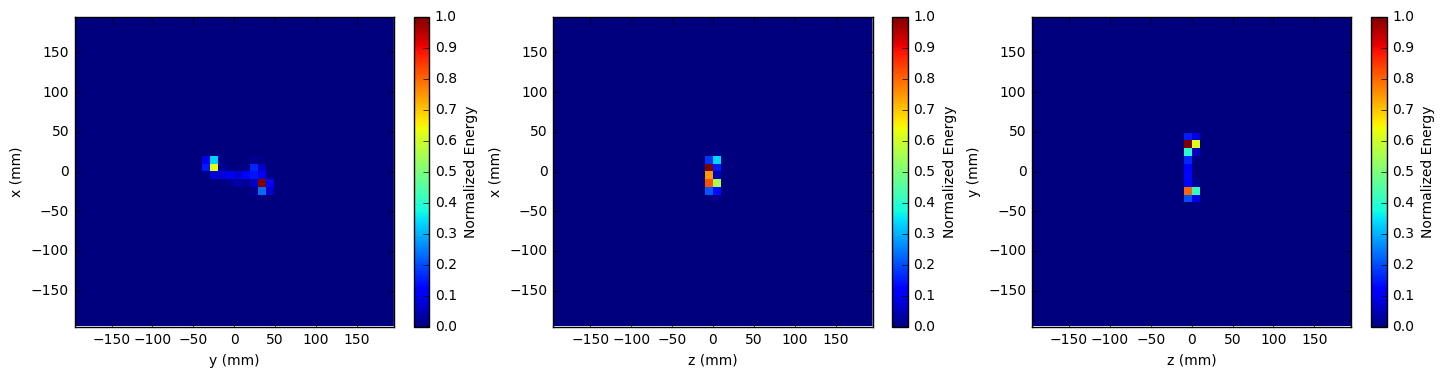

In [12]:
# plot one slice of one event
#RESET_maps_plot(x_train,5)
RESET_maps_plot_3D(x_train,4)

## Define and train the DNN

In [15]:
# set ld_model to true and specify the file to load in a previously defined/trained model
load_weights = True
mfile = 'models/weights_reset_V10_3D.h5'

if(load_weights):
    model = load_model(mfile)
else:
    
    # otherwise define the model
    #inputs = Input(shape=(xdim, ydim, 1))
    inputs = Input(shape=(xdim, ydim, zdim, 1))
    model = model_CNN_3D(inputs)
    
    # define callbacks (actions to be taken after each epoch of training)
    file_lbl = "{epoch:02d}-{loss:.4f}"
    filepath="weights-{0}.h5".format(file_lbl)
    checkpoint = callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
    tboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=False)
    #tboard_fix(tboard,model)
    lcallbacks = [checkpoint, tboard]            
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 40, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 20, 20, 32)    4032      
_________________________________________________________________
average_pooling3d_1 (Average (None, 10, 10, 10, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 10, 32)    128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 10, 10, 64)    55360     
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 10, 64)    256       
_________________________________________________________________
average_pooling3d_2 (Average (None, 5, 5, 5, 64)       0         
__________

In [ ]:
# train the model
hist = model.fit(x_train, y_train, shuffle=True, epochs=200, batch_size=20, verbose=1, validation_data=(x_val,y_val), callbacks=lcallbacks)

Train on 97000 samples, validate on 1000 samples
INFO:tensorflow:Summary name conv3d_1/kernel:0 is illegal; using conv3d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv3d_1/bias:0 is illegal; using conv3d_1/bias_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/gamma:0 is illegal; using batch_normalization_1/gamma_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/beta:0 is illegal; using batch_normalization_1/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_mean:0 is illegal; using batch_normalization_1/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_variance:0 is illegal; using batch_normalization_1/moving_variance_0 instead.
INFO:tensorflow:Summary name conv3d_2/kernel:0 is illegal; using conv3d_2/kernel_0 instead.
INFO:tensorflow:Summary name conv3d_2/bias:0 is illegal; using conv3d_2/bias_0 instead.
INFO:tensorflow:Summary name batch_normalization_2/gamma:0 is illegal; using batch_normalization_

KeyboardInterrupt: 

## Test the trained model

In [16]:
# compute the predictions
loss_and_metrics = model.evaluate(x_test, y_test);
y_pred = model.predict(x_test, batch_size=100, verbose=0)
print(loss_and_metrics)

1952/2000 [============================>.] - ETA: 0s[0.48308369112014771, 0.76249999999999996]


In [17]:
# create lists of values for signal vs. background curve
npoints = 100
fname_svsb = "plt/reset_V10_3D.h5"
bg_rej = []; si_eff = []
print("-- Calculating points...")
for thh in np.arange(0,1,1./npoints):
    nts = 0; ntb = 0
    ncs = 0; ncb = 0
    for ye,yp in zip(y_test,y_pred):
        if(ye == 0):
            ntb += 1  # add one background event
            if(yp < thh):
                ncb += 1  # add one correctly predicted background event

        if(ye == 1):
            nts += 1  # add one signal event
            if(yp >= thh):
                ncs += 1  # add one correctly predicted signal event
                
    si_eff.append(1.0*ncs/nts)
    bg_rej.append(1.0*ncb/ntb)
    #print("-- {0} of {1} ({2}%) correct background events; {3} of {4} ({5}%) correct signal events".format(ncb,ntb,1.0*ncb/ntb*100,ncs,nts,1.0*ncs/nts*100))

# save the results to file
print("-- Saving results...")
si_eff = np.array(si_eff); bg_rej = np.array(bg_rej)
f = tb.open_file(fname_svsb, 'w')
filters = tb.Filters(complib='blosc', complevel=9, shuffle=False)

atom    = tb.Atom.from_dtype(si_eff.dtype)
sarr    = f.create_earray(f.root, 'si_eff', atom, (0, npoints), filters=filters)
sarr.append([si_eff])

atom    = tb.Atom.from_dtype(bg_rej.dtype)
sarr    = f.create_earray(f.root, 'bg_rej', atom, (0, npoints), filters=filters)
sarr.append([bg_rej])

f.close()

-- Calculating points...
-- Saving results...


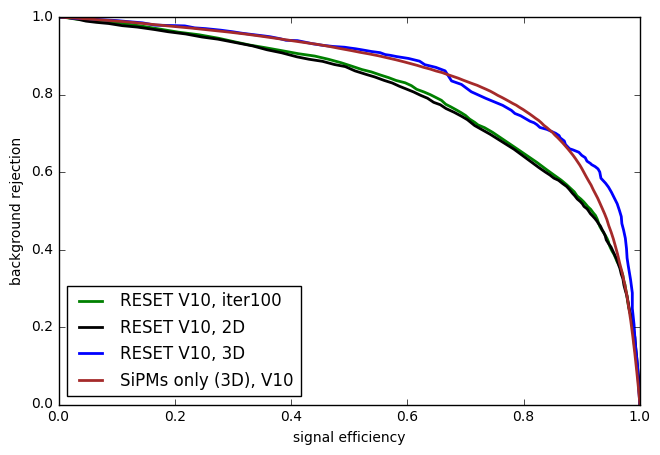

In [18]:
# plot signal vs. background curves
#fnames = ["plt/reset_V10_iter100.h5", "plt/reset_V10_iter500.h5", "plt/reset_V10_iter1000.h5", "plt/reset_V10_2D.h5", "plt/classification_V10_3Dconv.h5"]
#labels = ["RESET V10, iter100", "RESET V10, iter500", "RESET V10, iter1000", "RESET V10, latest", "SiPMs only (3D), V10"]
#colors = ["green", "black", "brown", "blue", "orange"]
fnames = ["plt/reset_V10_iter100.h5", "plt/reset_V10_2D.h5", "plt/reset_V10_3D.h5", "plt/classification_V10_3Dconv.h5"]
labels = ["RESET V10, iter100", "RESET V10, 2D", "RESET V10, 3D", "SiPMs only (3D), V10"]
colors = ["green", "black", "blue", "brown"]

# set up the plot
fig = plt.figure()
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

for nm,lb,co in zip(fnames,labels,colors):
    
    # read in the signal efficiency vs. background rejection information
    fn = tb.open_file(nm,'r')
    eff = fn.root.si_eff[0]
    bgr = fn.root.bg_rej[0]
    
    plt.plot(eff,bgr,color=co,label=lb,lw=2)
    fn.close()
    
plt.xlabel("signal efficiency")
plt.ylabel("background rejection")
plt.legend(loc=3)